# 1. Introduction

Nikki Satmaka - Batch 11

## Description

Dataset is taken from [Google Cloud Platform ftds-hacktiv8](https://console.cloud.google.com/bigquery?p=ftds-hacktiv8-project&d=phase1_assignments&t=heart-failure&page=table)

Context:
Cardiovascular diseases kill approximately 17 million people globally every year, and they mainly exhibit as myocardial infarctions and heart failures

This dataset contains the medical records of 299 heart failure patients collected at the Faisalabad Institute of Cardiology and at the Allied Hospital in Faisalabad (Punjab, Pakistan), during April–December 2015. The patients consisted of 105 women and 194 men, and their ages range between 40 and 95 years old

List of features:
1. `age` : Age
2. `anaemia` : Decrease of red blood cells or hemoglobin (boolean)
3. `creatinine_phosphokinase` : Level of the CPK enzyme in the blood (mcg/L)
4. `diabetes` : If the patient has diabetes (boolean)
5. `ejection_fraction` : Percentage of blood leaving the heart at each contraction (percentage)
6. `high_blood_pressure` : If the patient has hypertension (boolean)
7. `platelets` : Platelets in the blood (kiloplatelets/mL)
8. `serum_creatinine` : Level of serum creatinine in the blood (mg/dL)
9. `serum_sodium` : Level of serum sodium in the blood (mEq/L)
10. `sex` : Woman or man (binary)
11. `smoking` : If the patient smokes or not (boolean)
12. `time` : Follow-up period (days)
13. `DEATH_EVENT` : If the patient deceased during the follow-up period (boolean)


### Objective

- Predict if the patient would pass away during the follow-up period

### Problem Statement

- What features are going to be useful as predictors?

### Additional Information
- [Dataset Explanation](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5/tables/1)

### Data Collection

We first need to query our data from GCP's BiqQuery using this code

```SQL
SELECT *
FROM `ftds-hacktiv8-project.phase1_assignments.heart-failure`
```

# 2. Importing Libraries

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import joblib

import warnings
warnings.filterwarnings('ignore')

# For Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For Classification Problems
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Split Dataset and Standarize the Datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler

# Evaluate Classification Models
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score


pd.set_option('display.precision', 2)

sns.set_theme(style='darkgrid', palette='deep')

%matplotlib inline

### Useful Functions

In [2]:
def check_unique(data, col_type='both'):
    """
    Count the number of unique values in each features for 'numeric', 'categorical', or 'both'

    Parameters
    ----------
    data : DataFrame

    col_type : str
        The type of the column to filter. Either 'number', 'object', or 'both'

    Returns
    -------
    DataFrame
        Number of unique values of each features
    """

    # check if the column type is valid
    if col_type not in ('number', 'object', 'both'):
        raise ValueError('col_type must be either "number", "object", or "both"')

    # create a list if the column type is 'both'
    if col_type == 'both':
        col_type = ['number', 'object']

    # get the number of unique values in each column
    data_unique_count = pd.DataFrame.from_records(
        [(col, data[col].nunique()) for col in data.select_dtypes(include=col_type).columns],
        columns=['feats', 'num_unique']
    )

    return data_unique_count

In [3]:
def find_normal_boundaries(data, variable):
    """
    Calculate the boundaries outside which sit the outliers for a Gaussian distribution

    Parameters
    ----------
    data : DataFrame

    variable : string
        The feature of the DataFrame in which to the calculation will be performed

    Returns
    -------
    upper_boundary : float
        The computed upper boundary of the data

    lower_boundary : float
        The computed lower boundary of the data
    """

    upper_boundary = data[variable].mean() + 3 * data[variable].std()
    lower_boundary = data[variable].mean() - 3 * data[variable].std()

    return upper_boundary, lower_boundary

In [4]:
def find_skewed_boundaries(data, variable, distance):
    """
    Calculate the boundaries outside which sit the outliers for skewed distribution

    Parameters
    ----------
    data : DataFrame

    variable : string
        The feature of the DataFrame in which to the calculation will be performed

    distance : float
        The distance multiplier of IQR to calculate the boundaries

    Returns
    -------
    upper_boundary : float
        The computed upper boundary of the data

    lower_boundary : float
        The computed lower boundary of the data
    """

    IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)

    upper_boundary = data[variable].quantile(0.75) + (IQR * distance)
    lower_boundary = data[variable].quantile(0.25) - (IQR * distance)

    return upper_boundary, lower_boundary

In [5]:
def check_dist(data):
    """
    Check the Skewness and Distribution for each features in a dataset

    Parameters
    ----------
    data : DataFrame

    Returns
    -------
    DataFrame
        Skewness and distribution types of each features
    """

    # create a DataFrame containing the features of the dataset and their respective skewness
    data_skewness = pd.DataFrame(data.skew(), columns=['skew']).reset_index()

    # reset the index and make the features columns
    data_skewness = data_skewness.rename(columns={'index': 'feats'})

    # create a new column to describe whether the feature in the dataset is normal or skewed
    data_skewness['dist'] = np.where(
        (data_skewness['skew'] > -0.5) & (data_skewness['skew'] < 0.5),
        'normal',
        'skewed'
    )

    return data_skewness

In [6]:
def check_outlier(data, distance=1.5):
    """
    Check the outlier info for each features in a dataset

    Parameters
    ----------
    data : DataFrame

    distance : float
        The distance multiplier of IQR to calculate the boundaries for skewed distributions. It's either 1.5 or 3

    Returns
    -------
    DataFrame
        Outlier infos such as upper and lower boundary, and also the number of outliers for each features
    """

    if distance not in (1.5, 3):
        raise ValueError('Parameter distance only accepts numeric value of either 1.5 or 3')

    data_skewness = check_dist(data)

    # create a dictionary to store the outlier infos
    data_outlier = {
        'feats': [],
        'upper_bound': [],
        'lower_bound': [],
        'tot_right_tail': [],
        'tot_left_tail': [],
        'tot_right_tail_pct': [],
        'tot_left_tail_pct': [],
        'tot_outlier': [],
        'tot_outlier_pct': [],
    }

    # loop over each row in the `skewness` DataFrame
    # calculate each features upper and lower boundaries and the outlier percentage
    for row in data_skewness.index:
        col = data_skewness.iloc[row]['feats']

        if data_skewness.iloc[row]['dist'] == 'normal':
            upper_bound, lower_bound = find_normal_boundaries(data, col)
        else:
            upper_bound, lower_bound = find_skewed_boundaries(data, col, distance)

        tot_right_tail = len(data[data[col] > upper_bound])
        tot_left_tail = len(data[data[col] < lower_bound])
        tot_right_tail_pct = tot_right_tail / len(data) * 100
        tot_left_tail_pct = tot_left_tail / len(data) * 100
        tot_outlier =  tot_right_tail + tot_left_tail
        tot_outlier_pct = tot_right_tail_pct + tot_left_tail_pct

        data_outlier['feats'].append(col)
        data_outlier['upper_bound'].append(upper_bound)
        data_outlier['lower_bound'].append(lower_bound)
        data_outlier['tot_right_tail'].append(tot_right_tail)
        data_outlier['tot_left_tail'].append(tot_left_tail)
        data_outlier['tot_right_tail_pct'].append(tot_right_tail_pct)
        data_outlier['tot_left_tail_pct'].append(tot_left_tail_pct)
        data_outlier['tot_outlier'].append(tot_outlier)
        data_outlier['tot_outlier_pct'].append(tot_outlier_pct)
    
    data_outlier = pd.DataFrame(data_outlier)

    return data_outlier

In [7]:
def outlier_summary(data, distance=1.5):
    """
    Check the summary for outlier data, such as distribution and number of outliers for each features

    Parameters
    ----------
    data : DataFrame

    distance : float
        The distance multiplier of IQR to calculate the boundaries for skewed distributions. It's either 1.5 or 3

    Returns
    -------
    DataFrame
        Summary of outlier such as distribution and number of outliers for each features
    """

    data_skewness = check_dist(data)
    data_outlier = check_outlier(data, distance)

    outlier_summary_cols = ['feats', 'skew', 'dist', 'tot_outlier', 'tot_outlier_pct']

    data_outlier_summary = pd.merge(data_skewness, data_outlier, on=['feats'])
    data_outlier_summary = data_outlier_summary[outlier_summary_cols]

    return data_outlier_summary

In [8]:
def impute_na(data, variable, mean_value, median_value):
  """
  Function to Fill Missing Values with Zeroes, Mean, and Median
  """
  data[variable+'_mean'] = data[variable].fillna(mean_value)
  data[variable+'_median'] = data[variable].fillna(median_value)
  data[variable+'_zero'] = data[variable].fillna(0)
  
  return data

In [9]:
def plot_distribution(data, col, title, xlabel, ylabel, hue=None):
    """
    Plot the distribution of a feature for each death event
    Parameters
    ----------
    data : pandas dataframe
        dataframe containing the data
    col : string
        name of the feature
    title : string  
        title of the plot
    xlabel : string
        x-axis label
    ylabel : string
        y-axis label
    hue : string
        name of the column to be used for hue

    Returns
    -------
    None
    """
    plt.figure(figsize=(15, 5))
    sns.kdeplot(data=data, x=col, hue=hue, shade=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yticks([])
    plt.legend(labels=['Death', 'No Death'])
    plt.show()

# 3. Data Loading

In [10]:
# load dataset
df_ori = pd.read_csv('data/h8dsft_P1G3_nikki_satmaka.csv')
df = df_ori.copy()

# display the first 5 entries of the data
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,42.0,1,250,1,15,0,213000.0,1.3,136,0,0,65,1
1,46.0,0,168,1,17,1,271000.0,2.1,124,0,0,100,1
2,65.0,1,160,1,20,0,327000.0,2.7,116,0,0,8,1
3,53.0,1,91,0,20,1,418000.0,1.4,139,0,0,43,1
4,50.0,1,582,1,20,1,279000.0,1.0,134,0,0,186,0


In [11]:
# display the last 5 entries of the data
df.tail()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
294,63.0,1,122,1,60,0,267000.00,1.2,145,1,0,147,0
295,45.0,0,308,1,60,1,377000.00,1.0,136,1,0,186,0
296,70.0,0,97,0,60,1,220000.00,0.9,138,1,0,186,0
297,53.0,1,446,0,60,1,263358.03,1.0,139,1,0,215,0
298,50.0,0,582,0,62,1,147000.00,0.8,140,1,1,192,0


## Data Understanding

In [12]:
# check dataset shape
df.shape

(299, 13)

There are 299 entries and 13 columns of data.\
We do not have a lot of data

In [13]:
# check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


All data types are number

In [14]:
# check missing values in dataset
df.isna().sum().sort_values(ascending=False)

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Great there are no missing values

## Basic Characteristics of the Dataset

In [15]:
# check basic stats for numerical features
df.describe(percentiles=[0.5]).T

,count,mean,std,min,50%,max
age,299.0,60.83,11.89,40.0,60.0,95.0
anaemia,299.0,0.43,0.50,0.0,0.0,1.0
creatinine_phosphokinase,299.0,581.84,970.29,23.0,250.0,7861.0
diabetes,299.0,0.42,0.49,0.0,0.0,1.0
ejection_fraction,299.0,38.08,11.83,14.0,38.0,80.0
high_blood_pressure,299.0,0.35,0.48,0.0,0.0,1.0
platelets,299.0,263358.03,97804.24,25100.0,262000.0,850000.0
serum_creatinine,299.0,1.39,1.03,0.5,1.1,9.4
serum_sodium,299.0,136.63,4.41,113.0,137.0,148.0
sex,299.0,0.65,0.48,0.0,1.0,1.0


In [16]:
# check the cardinality of each nominal and ordinal features
for col in df.columns:
    if df[col].nunique() < 15:
        print(col, ':', df[col].nunique(), 'unique values, which contains', np.sort(df[col].unique()))

anaemia : 2 unique values, which contains [0 1]
diabetes : 2 unique values, which contains [0 1]
high_blood_pressure : 2 unique values, which contains [0 1]
sex : 2 unique values, which contains [0 1]
smoking : 2 unique values, which contains [0 1]
DEATH_EVENT : 2 unique values, which contains [0 1]


Let's cover some of the columns of this dataset
- `age`
    - Ranges from 40 to 95
    - Interval feature
    - Mean is only slightly higer than the median
    - Might be normally distributed
- `anaemia`
    - Nominal feature
    - Since it's either 0 or 1 and the median of the data is 0, the mode is also 0
    - Most of the patients do not have anaemia
- `creatinine_phosphokinase`
    - Ranges from 23 to 7861
    - Interval feature
    - Mean is way higher than the median by a long shot
    - Data is heavily right skewed
- `diabetes`
    - Nominal feature
    - Since it's either 0 or 1 and the median of the data is 0, the mode is also 0
    - Most patients do not have diabetes
- `ejection_fraction`
    - In percentages
    - Ranges from 14 to 80
    - Interval feature
    - Mean is only slightly higer than the median
    - Might be normally distributed
- `high_blood_pressure`
    - Nominal feature
    - Since it's either 0 or 1 and the median of the data is 0, the mode is also 0
    - Most patients do not have high blood pressure
- `platelets`
    - in kiloplatelets/mL
    - Ranges from 25,100 to 850,000
    - Interval feature
    - The mean is only slightly higher than the median
    - Might be normally distributed
- `serum_creatinine`
    - Ranges from 0.5 to 9.4
    - Interval feature
    - The mean is higher than the median
    - Might be right skewed
- `serum_sodium`
    - Ranges from 113 to 148
    - Interval feature
    - The mean is higher than the median
    - Might be right skewed
- ` sex`
    - Nominal feature
    - 0 for woman and 1 for man
    - Since it's either 0 or 1 and the median of the data is 1, the mode is also 1
    - Most patients are man
- `smoking`
    - Nominal feature
    - Since it's either 0 or 1 and the median of the data is 0, the mode is also 0
    - Most patients do not smoke
- `time`
    - In days
    - Ranges from 4 to 285 days
    - Mean is higher than the median
    - Might be right skewed
- `DEATH_EVENT`
    - Our target
    - Whether the patient died during the follow up period
    - Since it's either 0 or 1 and the median of the data is 0, the mode is also 0
    - Most patients did not die during the follow up period
    - I do not like how this column is written in caps, I'm going to make it lowercase

## Data Preparation

Make all columns in lowercase

In [17]:
df.columns = df.columns.str.lower()

print(df.columns.to_list())

['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'death_event']


Looks great

## Check for Dataset Imbalance

Check whether the target variable of the dataset is balance

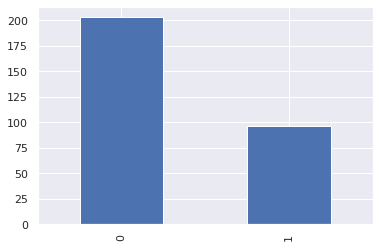

In [18]:
# check for imbalance in target variable
df['death_event'].value_counts().plot(kind='bar')
plt.show()

Since our dataset is imbalance, we need to stratify when splitting

## Splitting Dataset

We need to split the dataset into inference, train and test sets before we do any EDA.\
We do our EDA on the train set so as to not have any bias towards the whole dataset.

### Sample data for inference

In [19]:
# set random state
random_state = 42

In [20]:
# sample dataset for inference
df_inf = df.sample(10, random_state=random_state)

# remove inference set from original dataset
df_train_test = df.drop(df_inf.index).reset_index(drop=True)

# reset index for inference set
df_inf = df_inf.reset_index(drop=True)

print('df_inf Size:', df_inf.shape)

df_inf Size: (10, 13)


### Split train and test set


Since the target variable is imbalanced, we use stratified sampling

In [21]:
# we use stratified sampling to ensure that the distribution of the target variable is balanced
df_train, df_test = train_test_split(
    df_train_test,
    test_size=0.20,
    random_state=random_state,
    stratify=df_train_test['death_event']
)

print('df_train Size:', df_train.shape)
print('df_test Size:', df_test.shape)

df_train Size: (231, 13)
df_test Size: (58, 13)


In [22]:
# backup the train set that we are gonna perform EDA on
df_train_ori = df_train.copy()

# 4. Exploratory Data Analysis

## Source of dataset

The dataset seems to have come from [BMC](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5)

## Follow-up Period and Death Event

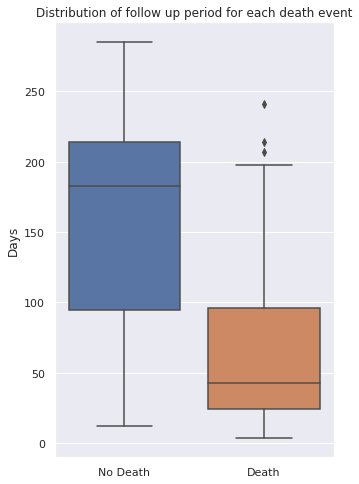

In [23]:
# plot the distribution of follow up period for each death event
plt.figure(figsize=(5, 8))
sns.boxplot(data=df_train, x='death_event', y='time')
plt.title('Distribution of follow up period for each death event')
plt.xlabel(None)
plt.ylabel('Days')
plt.xticks([0, 1], ['No Death', 'Death'])

plt.show()

We can see that the case of decease, happened mostly within the 50-day-mark. Most patients who did not pass away, survived and could attend the follow up period until around 200 days. I assume that after this safe mark, the follow up period is performed less frequently

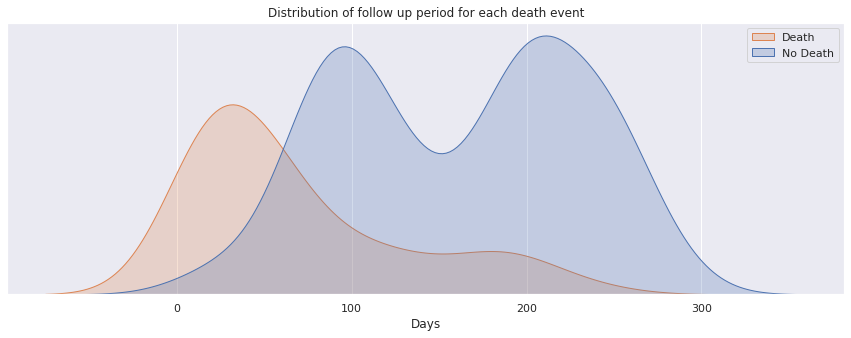

In [24]:
# plot the distribution of follow up period for each death event
plot_distribution(
    data=df_train,
    col='time',
    title='Distribution of follow up period for each death event',
    xlabel='Days',
    ylabel=None,
    hue='death_event'
)

We could see in more detail by plotting the time in the horizontal axis. The same insights for the deceased that it happens mostly around the 50-day-follow-up-period. There is however two bulges for the survivors, where they were followed up until around 100 days and 200 days. We could conclude that the crucial period to monitor is within those 50-day-period where the event of decease mostly happen

## Age and Death Event

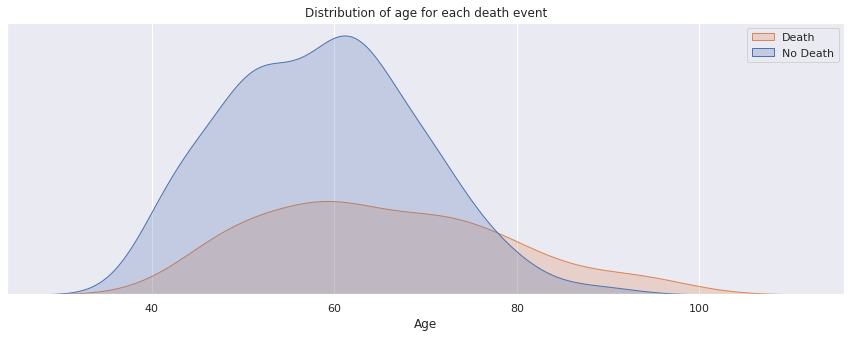

In [25]:
# plot the distribution of age for each death event
plot_distribution(
    data=df_train,
    col='age',
    title='Distribution of age for each death event',
    xlabel='Age',
    ylabel=None,
    hue='death_event'
)

The age distribution is quite similar between the deceased and not deceased patients, however we tend to have more bulge of the profile around the 50-year-old-mark for the not deceased patients. It seems like the younger patients have a bigger chance of surviving. This can also be seen by the steep slope on the right side of the profile for the not deceased, while the deceased have a more modest slope.

## CPK Enzyme and Death Event

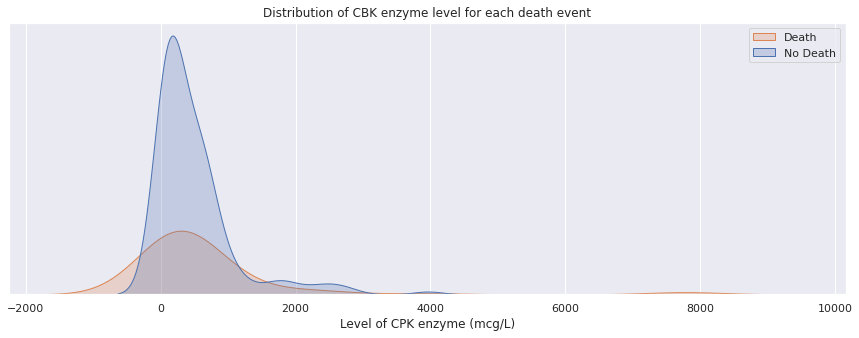

In [26]:
# plot distribution of creatinine phosphokinase for each death event
plot_distribution(
    data=df_train,
    col='creatinine_phosphokinase',
    title='Distribution of CBK enzyme level for each death event',
    xlabel='Level of CPK enzyme (mcg/L)',
    ylabel=None,
    hue='death_event'
)


There's not much of a difference between the profile for the deceased and the not deceased in terms of the mode. However, the not deceased has a much steeper slope. That means that the CPK enzyme is much more varied for the deceased, as can also be seen by the outlier located far on the right

## Ejection Fraction and Death Event

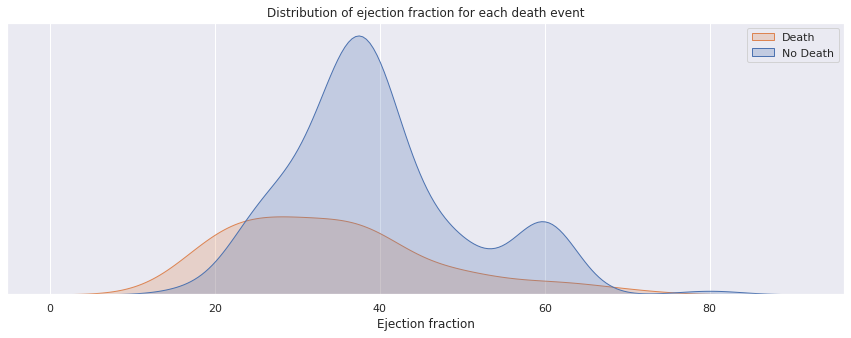

In [27]:
# plot distribution of ejection fraction for each death event
plot_distribution(
    data=df_train,
    col='ejection_fraction',
    title='Distribution of ejection fraction for each death event',
    xlabel='Ejection fraction',
    ylabel=None,
    hue='death_event'
)

We can see that the distribution for the deceased and not deceased are different. The deceased has a much modest slope, meanwhile, the not deceased has a steeper slope, and in general has a higher ejection fraction compared to the deceased.

## Serum Creatinine and Death Event

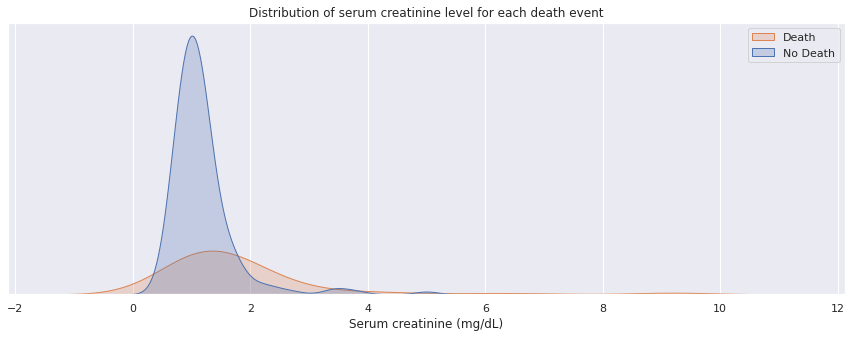

In [28]:
# plot distribution of serum creatinine for each death event
plot_distribution(
    data=df_train,
    col='serum_creatinine',
    title='Distribution of serum creatinine level for each death event',
    xlabel='Serum creatinine (mg/dL)',
    ylabel=None,
    hue='death_event'
)

The mode of the profile is quite similar for the serum creatinine. It's just that the not deceased is more focused with the steeper slope, as the serum creatinine is more varied on the deceased, as can be seen that there are outlier on the right side.

## Serum Sodium and Death Event

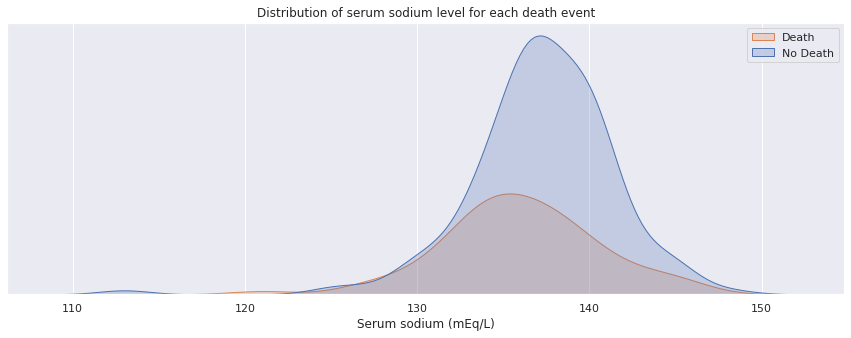

In [29]:
# plot distribution of serum sodium for each death event
plot_distribution(
    data=df_train,
    col='serum_sodium',
    title='Distribution of serum sodium level for each death event',
    xlabel='Serum sodium (mEq/L)',
    ylabel=None,
    hue='death_event'
)

We could see that the bulge of the distribution for the not deceased tends to be higher on the serum sodium scale. This could mean that people who have higher level of serum sodium in the blood tend to have a higher probability of surviving

# 5. Data Preprocessing

In [30]:
# restore the train set from the backup
df_train = df_train_ori.copy()

In [31]:
# split between features and target
X_train = df_train.drop(['death_event'], axis=1)
y_train = df_train['death_event'].copy()

X_test = df_test.drop(['death_event'], axis=1)
y_test = df_test['death_event'].copy()

## Categorizing Features

Categorize the features based on the variable type of the features and the data it represents
- Numeric (Interval): Features which have equally spaced interval between unique values
- Categorical (Nominal): Features which have no intrinsic ordering to the unique values
- Ordinal: Features which have clear ordering but do not have equally spaced intervals between unique values

In [32]:
# categorizing features
num_cols = [
    'age',
    'creatinine_phosphokinase',
    'ejection_fraction',
    'platelets',
    'serum_creatinine',
    'serum_sodium',
    'time'
]

nom_cols = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

## Handling Outliers

In [33]:
# check outlier summary only on numerical features
outlier_summary(X_train[num_cols], 1.5)

,feats,skew,dist,tot_outlier,tot_outlier_pct
0,age,0.49,normal,0,0.00
1,creatinine_phosphokinase,5.04,skewed,20,8.66
2,ejection_fraction,0.69,skewed,26,11.26
3,platelets,0.94,skewed,14,6.06
4,serum_creatinine,4.56,skewed,20,8.66
5,serum_sodium,-0.96,skewed,2,0.87
6,time,0.10,normal,0,0.00


1. `Trimming`: if outliers' percentage < 5%
2. `Capping`: if outliers' percentage 5% - 15%
3. `None`: if outliers' percentage > 15%

In [34]:
# check outlier details
check_outlier(X_train[num_cols], 1.5)

,feats,upper_bound,lower_bound,tot_right_tail,tot_left_tail,tot_right_tail_pct,tot_left_tail_pct,tot_outlier,tot_outlier_pct
0,age,95.79,25.62,0,0,0.00,0.00,0,0.00
1,creatinine_phosphokinase,1285.50,-590.50,20,0,8.66,0.00,20,8.66
2,ejection_fraction,55.00,15.00,26,0,11.26,0.00,26,11.26
3,platelets,445500.00,69500.00,10,4,4.33,1.73,14,6.06
4,serum_creatinine,2.27,0.08,20,0,8.66,0.00,20,8.66
5,serum_sodium,149.00,125.00,0,2,0.00,0.87,2,0.87
6,time,370.85,-106.04,0,0,0.00,0.00,0,0.00


Observing the dataset, I've decided that I'm not going to handle the outlier manually and instead will use *RobustScaler* to handle and scale the skewed dataset\
I've actually tested out a couple different combinations using *winsorization, minmax scaling, and standard scaling*, and found that using *robust scaling* yielded a higher score

## Handling Missing Values

In [35]:
# check missing values in train set
X_train.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
dtype: int64

In [36]:
# check missing values in train target
y_train.isna().sum()

0

In [37]:
# check missing values in test set
X_test.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
dtype: int64

In [38]:
# check missing values in test target
y_test.isna().sum()

0

Great! There are no missing values in train nor test features and target

## Feature Selection

### Heatmap Correlation Matrix for Numerical Features

We look at the Spearman's correlation matrix to find out the relation between features and target

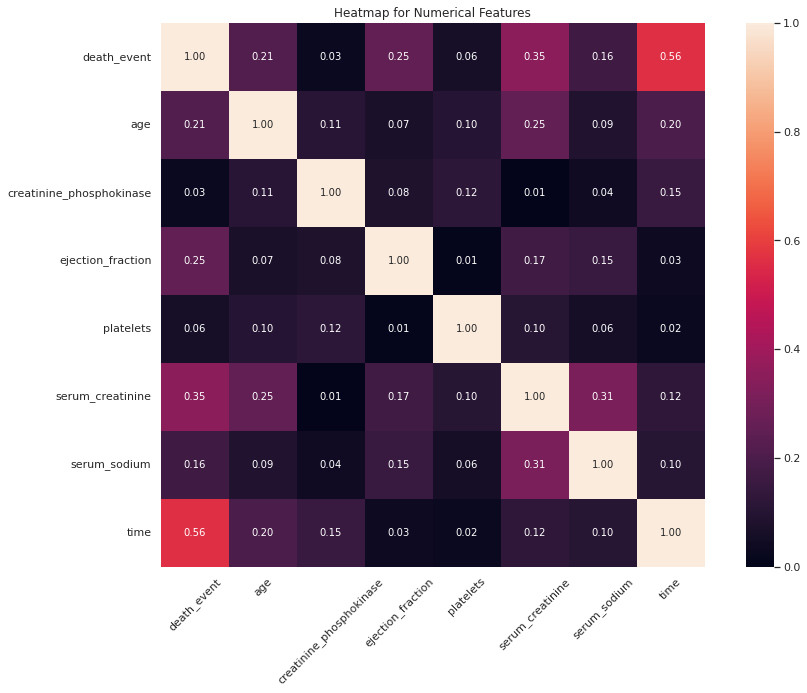

In [39]:
# Heatmap Correlation Matrix
plt.figure(figsize=(15,10))

sns.heatmap(
    pd.concat([y_train, X_train[num_cols]], axis=1).corr('spearman').abs(),
    annot=True, vmin=0, vmax=1, fmt='.2f', square=True)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Heatmap for Numerical Features')

plt.show()


- There are quite a high correlation between `time` and our target `death_event`
- There are some moderate correlation between `age`, `ejection_fraction`, `serum_creatinine`, `serum_sodium` and our target `death_event`
- There are no features that are highly correlated with each other
- For this research, I'm going to filter out features that have less than `0.20` Spearman's correlation value towards the target variable
- I do think we need to have a deeper look to the feature `time`. `death_event` is by definition the event of decease within the follow up period. So this means that these two variables are sure to be correlated to each other.
- However, it does mean that `time` would be useful as a predictor. By common sense, just because someone is followed up more frequently, does not mean that it would change the probability of dying. Therefore, I'm going to drop this feature as well
    - I've actually already tested running a model using this feature and it would result in an overfitted model

### Heatmap Correlation Matrix for Categorical Features

We look at the Spearman's correlation matrix to find out the relation between features and target

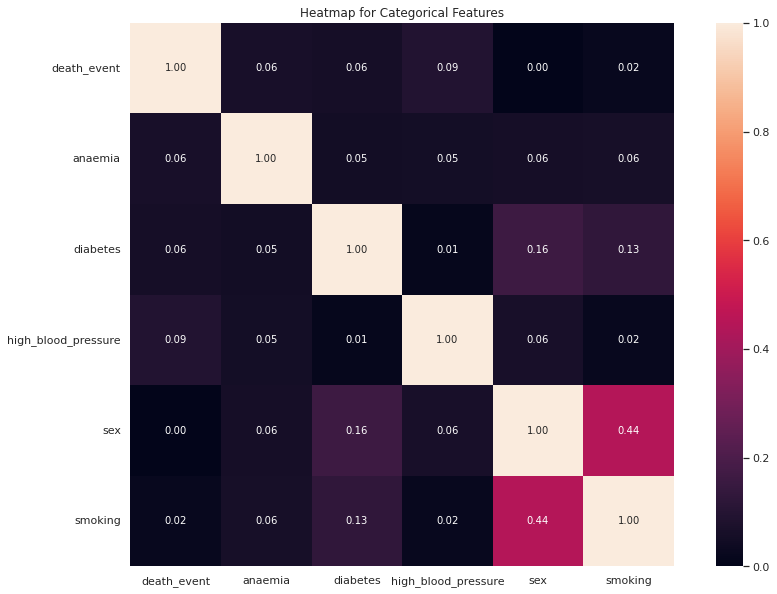

In [40]:
# Heatmap Correlation Matrix
plt.figure(figsize=(15,10))

sns.heatmap(
    pd.concat([y_train, X_train[nom_cols]], axis=1).corr('spearman').abs(),
    annot=True, vmin=0, vmax=1, fmt='.2f', square=True)
plt.yticks(rotation=0)
plt.title('Heatmap for Categorical Features')

plt.show()


- The correlations here are lower compared to the numerical features we have
- The highest correlation here is held by `high_blood_pressure`
- For this research, I'm going to drop all these categorical features since they have low correlation
- I've actually run multiple tests and the model performed better without them in terms of being a good fit and recall scores

### Categorizing Selected Features

In [41]:
# create list of numerical features with normal distribution
num_cols_norm = ['age']

# create list of numerical features with skew
num_cols_skew = [
    'ejection_fraction',
    'serum_creatinine'
]

# create final list of nominal features
nom_cols = []

Great! We have finalized our feature list.
We also separated numerical features with different types of distribution just in case we want to scale them using different methods

### List of Features

These are the predictors we're going to use

In [42]:
# print out list of predictors
print('Numerical Features:')
print(num_cols_norm + num_cols_skew)
print('=' * 50)
print('Categorical Features:')
print(nom_cols)

Numerical Features:
['age', 'ejection_fraction', 'serum_creatinine']
Categorical Features:
[]


### Create Pipeline

Create a pipeline based on how we would engineer the features, whether to scale or to encode
- We will create multiple pipeline for scaling because each features and each models require different procedures in which we handle it
- All categorical features will use one hot encoder, though we do not use one

In [43]:
# create pipeline for standardization
std_pipe = Pipeline([
    ('std_scaler', StandardScaler())
])

# create pipeline for min max scaling
min_max_pipe = Pipeline([
    ('min_max_scaler', MinMaxScaler())
])

# create pipeline for normalizer
power_pipe = Pipeline([
    ('power_transformer', PowerTransformer())
])

# create pipeline for robust scaler
robust_pipe = Pipeline([
    ('robust_scaler', RobustScaler())
])

# create pipeline for categorical features
nom_pipe = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

### Create Column Transformer

Create a `ColumnTransformer` object based on the pipeline we have created\
All normally distributed numerical features will use *StandardScaler*\
The rest will varied and tested

In [44]:
# create column transformer object using standard scaler
ct_std = ColumnTransformer([
    ('num_norm', std_pipe, num_cols_norm),
    ('num_skew', std_pipe, num_cols_skew),
    ('nom', 'passthrough', nom_cols)
])

# create column transformer object using min max scaler
ct_mm = ColumnTransformer([
    ('num_norm', std_pipe, num_cols_norm),
    ('num_skew', min_max_pipe, num_cols_skew),
    ('nom', 'passthrough', nom_cols)
])

# create column transformer object using power transform
ct_pt = ColumnTransformer([
    ('num_norm', std_pipe, num_cols_norm),
    ('num_skew', power_pipe, num_cols_skew),
    ('nom', 'passthrough', nom_cols)
])

# create column transformer object using robust scaler
ct_rs = ColumnTransformer([
    ('num_norm', std_pipe, num_cols_norm),
    ('num_skew', robust_pipe, num_cols_skew),
    ('nom', 'passthrough', nom_cols)
])


# 6. Model Definition

- Target: Predicting whether the event of decease would happen to the patient within the follow up period

    The target that we're going to predict is a label, which means we are going to make a classification model.
    In this case, we want to minimize the situation in which we incorrectly predicts a patient would not pass away (when the patient is in fact would), or as in the statistical term, **False Negative**

- Predictors: The features I'm going to use are
    - Numerical Features:
        - ['age', 'ejection_fraction', 'serum_creatinine']

- Models: The Supervised Learning Algorithms I'm going to test
    - Random Forest
    - Gradient Boosting

## Random Forest

I'm going to use *RobustScaler* since I didn't handle the outlier for the skewed feature.\
The normally distributed features will be scaled using *StandardScaler*

In [45]:
# declare random forest classifier
rf = RandomForestClassifier(random_state=random_state)

# create pipeline for random forest classifier
rf_pipe = Pipeline([
    ('ct', ct_rs),
    ('rf', rf)
])


## Gradient Boosting

I'm going to use *RobustScaler* since I didn't handle the outlier for the skewed feature.\
The normally distributed features will be scaled using *StandardScaler*

In [46]:
# declare gradient boosting classifier
gbc = GradientBoostingClassifier(random_state=random_state)

# create pipeline for gradient boosting classifier
gbc_pipe = Pipeline([
    ('ct', ct_rs),
    ('gbc', gbc)
])

# 7. Model Training

In [47]:
# create a dictionary of models
models = {
    'rf': rf_pipe,
    'gbc': gbc_pipe
}

## Cross Validating Base Models

Since the dataset is imbalance, we are going to evaluate our models based on **F1 Score**\
It's also important that we reduce the number of *False Negatives*, hence a high **Recall** is also important

In [48]:
# create a dict to store the cross validation scores
cv_results = {
    'models': [],
    'f1_score_mean': [],
    'f1_score_std': [],
    'recall_score_mean': [],
    'recall_score_std': []
} 

# loop over each each models and perform cross validation
for name, model in models.items():
    # fit the model
    model.fit(X_train, y_train)
    # get cross validation scores
    scores = cross_validate(
        model, X_train, y_train,
        scoring=['f1_weighted', 'recall'],
        cv=5
    )

    # store the cross validation scores
    cv_results['models'].append(name)
    cv_results['f1_score_mean'].append(scores['test_f1_weighted'].mean().round(2))
    cv_results['f1_score_std'].append(scores['test_f1_weighted'].std().round(4))
    cv_results['recall_score_mean'].append(scores['test_recall'].mean().round(2))
    cv_results['recall_score_std'].append(scores['test_recall'].std().round(4))

# create a dataframe from the dict
cv_results_df = pd.DataFrame(cv_results)

# 8. Model Evaluation

In [49]:
# display the dataframe sorted by f1 score and recall score
cv_results_df.sort_values(by=['f1_score_mean', 'recall_score_mean'], ascending=False)

,models,f1_score_mean,f1_score_std,recall_score_mean,recall_score_std
0,rf,0.74,0.04,0.55,0.15
1,gbc,0.72,0.05,0.45,0.16


- Based on the cross validation score of *f1_weighted* and *recall*, we can see that **Random Forest** has a better performance than **Gradient Boosting**
- However, I'm still going to perform hyperparameter tuning on both models

## Hyperparameter Tuning

Run on both models using *RandomizedSearchCV*

In [50]:
# create parameter grid for random forest classifier
params_rf = {
    'rf__max_depth': [3, 5, 7, 10, None],
    'rf__min_samples_leaf': [1, 2, 3, 4],
    'rf__min_samples_split': [2, 3, 4, 5],
}

In [51]:
# create parameter grid for gradient boosting classifier
params_gbc = {
    'gbc__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'gbc__max_depth': [3, 5, 7, 10, None],
    'gbc__min_samples_leaf': [1, 2, 3, 4],
}

In [52]:
# create randomized search object for random forest classifier
rf_rand = RandomizedSearchCV(
    rf_pipe,
    params_rf,
    cv=5,
    scoring='f1_weighted',
    n_iter=20,
    random_state=random_state
)

In [53]:
# create randomized search object for gradient boosting classifier
gbc_rand = RandomizedSearchCV(
    gbc_pipe,
    params_gbc,
    cv=5,
    scoring='f1_weighted',
    n_iter=25,
    random_state=random_state
)

In [54]:
%%time

# perform randomized search for random forest classifier
rf_rand.fit(X_train, y_train)

CPU times: user 15.3 s, sys: 126 ms, total: 15.4 s
Wall time: 15.4 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(transformers=[('num_norm',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['age']),
                                                                              ('num_skew',
                                                                               Pipeline(steps=[('robust_scaler',
                                                                                                RobustScaler())]),
                                                                               ['ejection_fraction',
                                                                                'serum_creatinine']),
                                                                              ('nom',
                                                                               'passthrough',
                                                                               [])])),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20,
                   param_distributions={'rf__max_depth': [3, 5, 7, 10, None],
                                        'rf__min_samples_leaf': [1, 2, 3, 4],
                                        'rf__min_samples_split': [2, 3, 4, 5]},
                   random_state=42, scoring='f1_weighted')

In [55]:
%%time

# perform randomized search for gradient boosting classifier
gbc_rand.fit(X_train, y_train)

CPU times: user 18.3 s, sys: 527 µs, total: 18.3 s
Wall time: 18.3 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(transformers=[('num_norm',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['age']),
                                                                              ('num_skew',
                                                                               Pipeline(steps=[('robust_scaler',
                                                                                                RobustScaler())]),
                                                                               ['ejection_fraction',
                                                                                'serum_creatinine']),
                                                                              ('nom',
                                                                               'passthrough',
                                                                               [])])),
                                             ('gbc',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_iter=25,
                   param_distributions={'gbc__learning_rate': [0.1, 0.2, 0.3,
                                                               0.4, 0.5],
                                        'gbc__max_depth': [3, 5, 7, 10, None],
                                        'gbc__min_samples_leaf': [1, 2, 3, 4]},
                   random_state=42, scoring='f1_weighted')

In [56]:
# print the best parameters for random forest classifier based on randomized search
print(f'Best Parameters for Random Forest Classifier (Randomized Search): {rf_rand.best_params_}')

# print the best score for random forest classifier based on randomized search
print(f'Best Score for Random Forest Classifier (Randomized Search): {rf_rand.best_score_:.2f}')

Best Parameters for Random Forest Classifier (Randomized Search): {'rf__min_samples_split': 3, 'rf__min_samples_leaf': 4, 'rf__max_depth': 7}
Best Score for Random Forest Classifier (Randomized Search): 0.75


In [57]:
# print the best parameters for gradient boosting classifier based on randomized search
print(f'Best Parameters for Gradient Boosting Classifier (Randomized Search): {gbc_rand.best_params_}')

# print the best score for gradient boosting classifier based on randomized search
print(f'Best Score for Gradient Boosting Classifier (Randomized Search): {gbc_rand.best_score_:.2f}')

Best Parameters for Gradient Boosting Classifier (Randomized Search): {'gbc__min_samples_leaf': 2, 'gbc__max_depth': 10, 'gbc__learning_rate': 0.2}
Best Score for Gradient Boosting Classifier (Randomized Search): 0.74


In [58]:
# assign the best estimator to the final random forest classifier model
final_rf = rf_rand.best_estimator_

# assign the best estimator to the final gradient boosting classifier model
final_gbc = gbc_rand.best_estimator_

Running this randomized search resulted in:
- Around 30s to run, be it *Random Forest* or *Gradient Boosting*
- For *Random Forest Classifier*
    - Best Parameters for Random Forest Classifier (Randomized Search):
        - `{'rf__min_samples_split': 3, 'rf__min_samples_leaf': 4, 'rf__max_depth': 7}`
    - Best Score for Random Forest Classifier (Randomized Search): 0.75
- For *Gradient Boosting Classifier*
    - Best Parameters for Gradient Boosting Classifier (Randomized Search):
        - `{'gbc__min_samples_leaf': 2, 'gbc__max_depth': 10, 'gbc__learning_rate': 0.2}`
    - Best Score for Gradient Boosting Classifier (Randomized Search): 0.74

## Evaluate Hyperparameter Tuning Search Results

In [59]:
# predict train set using the base random forest classifier
y_pred_train_rf = rf_pipe.predict(X_train)

# predict test set using the base random forest classifier
y_pred_test_rf = rf_pipe.predict(X_test)

# predict train set using the final random forest classifier
y_pred_train_final_rf = final_rf.predict(X_train)

# predict test set using the final random forest classifier
y_pred_test_final_rf = final_rf.predict(X_test)

In [60]:
# predict train set using the base gradient boosting classifier
y_pred_train_gbc = gbc_pipe.predict(X_train)

# predict test set using the base gradient boosting classifier
y_pred_test_gbc = gbc_pipe.predict(X_test)

# predict train set using the final gradient boosting classifier
y_pred_train_final_gbc = final_gbc.predict(X_train)

# predict test set using the final gradient boosting classifier
y_pred_test_final_gbc = final_gbc.predict(X_test)

In [61]:
# prepare target names for classification report
target_names = ['No Death', 'Death']

In [62]:
# create a dictionary containing the list of base and final predictions
models_to_evaluate = {
    'Base Random Forest Classifier': [y_pred_train_rf, y_pred_test_rf],
    'Final Random Forest Classifier': [y_pred_train_final_rf, y_pred_test_final_rf],
    'Base Gradient Boosting Classifier': [y_pred_train_gbc, y_pred_test_gbc],
    'Final Gradient Boosting Classifier': [y_pred_train_final_gbc, y_pred_test_final_gbc]
}

### Summary of F1 and Recall Score

In [63]:
# create a dict to store the classification report summarized
report_summary = {
    'models': [],
    'f1_scores_train': [],
    'f1_scores_test': [],
    'recall_scores_train': [],
    'recall_scores_test': [],
    'roc_auc_scores_train': [],
    'roc_auc_scores_test': []
} 

# loop over each each models and perform cross validation
for name, preds in models_to_evaluate.items():
    # get f1 score training set
    f1_score_train = f1_score(y_train, preds[0], average='weighted')
    # get f1 score test set
    f1_score_test = f1_score(y_test, preds[1], average='weighted')
    # get recall score training set
    recall_score_train = recall_score(y_train, preds[0], average='weighted')
    # get recall score test set
    recall_score_test = recall_score(y_test, preds[1], average='weighted')
    # get roc auc score training set
    roc_auc_score_train = roc_auc_score(y_train, preds[0], average='weighted')
    # get roc auc score test set
    roc_auc_score_test = roc_auc_score(y_test, preds[1], average='weighted')

    # store the scores
    report_summary['models'].append(name)
    report_summary['f1_scores_train'].append(f1_score_train)
    report_summary['f1_scores_test'].append(f1_score_test)
    report_summary['recall_scores_train'].append(recall_score_train)
    report_summary['recall_scores_test'].append(recall_score_test)
    report_summary['roc_auc_scores_train'].append(roc_auc_score_train)
    report_summary['roc_auc_scores_test'].append(roc_auc_score_test)

# create a dataframe from the dict
report_summary_df = pd.DataFrame(report_summary)

In [64]:
# display the dataframe
report_summary_df

,models,f1_scores_train,f1_scores_test,recall_scores_train,recall_scores_test,roc_auc_scores_train,roc_auc_scores_test
0,Base Random Forest Classifier,0.99,0.79,0.99,0.79,0.99,0.73
1,Final Random Forest Classifier,0.82,0.81,0.83,0.81,0.77,0.77
2,Base Gradient Boosting Classifier,0.91,0.76,0.91,0.78,0.87,0.70
3,Final Gradient Boosting Classifier,0.99,0.76,0.99,0.78,0.99,0.70


- We can see from the comparison between the train score and the test score for each model to determine whether the model is a good fit
- We conclude that the base model, be it *Random Forest* or *Gradient Boosting* are both overfit as the f1 train score are both higher then the respective f1 test score
- The *Final Random Forest* method which have been tuned resulted in a good fit as there's not that much different between the train and test scores
- The *Final Gradient Boosting* actually became even more overfit as the gap became wider
- Therefore, the *Final Random Forest* will be our main model to further analyze

### Detailed Evaluation for Random Forest Classifier

In [65]:
# print out the classification report for each model
for name, preds in models_to_evaluate.items():
    if 'Random Forest' in name:
        print(f'\nClassification Report for {name} Training Set:')
        print(classification_report(y_train, preds[0], target_names=target_names))
        print(f'\nClassification Report for {name} Test Set:')
        print(classification_report(y_test, preds[1], target_names=target_names))


Classification Report for Base Random Forest Classifier Training Set:
              precision    recall  f1-score   support

    No Death       0.99      0.99      0.99       158
       Death       0.99      0.99      0.99        73

    accuracy                           0.99       231
   macro avg       0.99      0.99      0.99       231
weighted avg       0.99      0.99      0.99       231


Classification Report for Base Random Forest Classifier Test Set:
              precision    recall  f1-score   support

    No Death       0.82      0.90      0.86        40
       Death       0.71      0.56      0.63        18

    accuracy                           0.79        58
   macro avg       0.77      0.73      0.74        58
weighted avg       0.79      0.79      0.79        58


Classification Report for Final Random Forest Classifier Training Set:
              precision    recall  f1-score   support

    No Death       0.83      0.94      0.88       158
       Death       0.83    

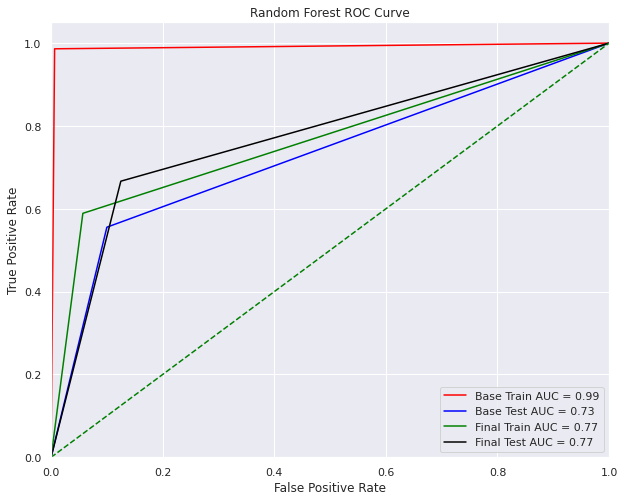

In [66]:
# plot roc curve for train set
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_pred_train_rf)
# calculate auc score for train set
roc_auc_train_rf = auc(fpr_train_rf, tpr_train_rf)

# plot roc curve for test set
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_pred_test_rf)
# calculate auc score for test set
roc_auc_test_rf = auc(fpr_test_rf, tpr_test_rf)

# plot roc curve for train set using the final model
fpr_train_final_rf, tpr_train_final_rf, _ = roc_curve(y_train, y_pred_train_final_rf)
# calculate auc score for train set using the final model
roc_auc_train_final_rf = auc(fpr_train_final_rf, tpr_train_final_rf)

# plot roc curve for test set using the final model
fpr_test_final_rf, tpr_test_final_rf, _ = roc_curve(y_test, y_pred_test_final_rf)
# calculate auc score for test set using the final model
roc_auc_test_final_rf = auc(fpr_test_final_rf, tpr_test_final_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_train_rf, tpr_train_rf, color='red', label=f'Base Train AUC = {roc_auc_train_rf:.2f}')
plt.plot(fpr_test_rf, tpr_test_rf, color='blue', label=f'Base Test AUC = {roc_auc_test_rf:.2f}')
plt.plot(fpr_train_final_rf, tpr_train_final_rf, color='green', label=f'Final Train AUC = {roc_auc_train_final_rf:.2f}')
plt.plot(fpr_test_final_rf, tpr_test_final_rf, color='black', label=f'Final Test AUC = {roc_auc_test_final_rf:.2f}')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.show()

- Looking at the classification report and the AUC score, we can see that tuning has made the model from overfit to a good fit. Hence viable to be run. However, we still need to look whether the metrics is good enough for our purpose
- We need to detect the possibility of decease as much as possible, therefore we need to minimize **False Negatives**, hence we need a high recall score
- We successfully increased the recall score after tuning, as we can see that we now have a recall score of `0.67`
- This however, is not enough for us, as just having a few **False Negatives** could be detrimental to the lives of our patients
- Therefore, even though this model is now a good fit and we have successfully minimize the **False Negatives**, it is still not up to the standard needed and much improvements have to be made

### Detailed Evaluation for Gradient Boosting Classifier

In [67]:
# print out the classification report for each model
for name, preds in models_to_evaluate.items():
    if 'Gradient Boosting' in name:
        print(f'\nClassification Report for {name} Training Set:')
        print(classification_report(y_train, preds[0], target_names=target_names))
        print(f'\nClassification Report for {name} Test Set:')
        print(classification_report(y_test, preds[1], target_names=target_names))


Classification Report for Base Gradient Boosting Classifier Training Set:
              precision    recall  f1-score   support

    No Death       0.89      0.99      0.94       158
       Death       0.98      0.74      0.84        73

    accuracy                           0.91       231
   macro avg       0.94      0.87      0.89       231
weighted avg       0.92      0.91      0.91       231


Classification Report for Base Gradient Boosting Classifier Test Set:
              precision    recall  f1-score   support

    No Death       0.80      0.90      0.85        40
       Death       0.69      0.50      0.58        18

    accuracy                           0.78        58
   macro avg       0.75      0.70      0.71        58
weighted avg       0.77      0.78      0.76        58


Classification Report for Final Gradient Boosting Classifier Training Set:
              precision    recall  f1-score   support

    No Death       0.99      1.00      0.99       158
       Death   

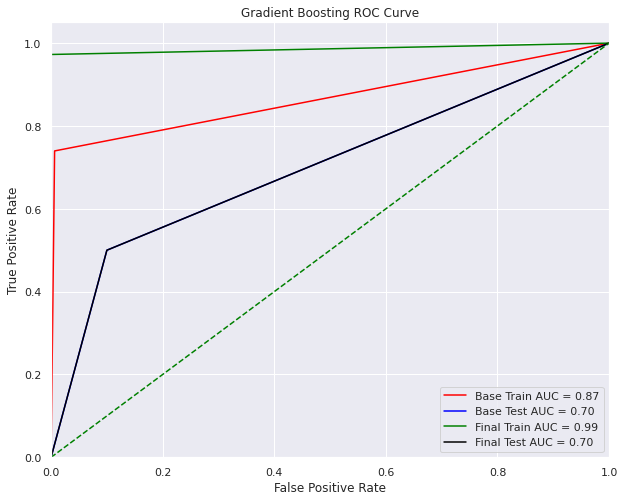

In [68]:
# plot roc curve for train set
fpr_train_gbc, tpr_train_gbc, _ = roc_curve(y_train, y_pred_train_gbc)
# calculate auc score for train set
roc_auc_train_gbc = auc(fpr_train_gbc, tpr_train_gbc)

# plot roc curve for test set
fpr_test_gbc, tpr_test_gbc, _ = roc_curve(y_test, y_pred_test_gbc)
# calculate auc score for test set
roc_auc_test_gbc = auc(fpr_test_gbc, tpr_test_gbc)

# plot roc curve for train set using the final model
fpr_train_final_gbc, tpr_train_final_gbc, _ = roc_curve(y_train, y_pred_train_final_gbc)
# calculate auc score for train set using the final model
roc_auc_train_final_gbc = auc(fpr_train_final_gbc, tpr_train_final_gbc)

# plot roc curve for test set using the final model
fpr_test_final_gbc, tpr_test_final_gbc, _ = roc_curve(y_test, y_pred_test_final_gbc)
# calculate auc score for test set using the final model
roc_auc_test_final_gbc = auc(fpr_test_final_gbc, tpr_test_final_gbc)

plt.figure(figsize=(10, 8))
plt.plot(fpr_train_gbc, tpr_train_gbc, color='red', label=f'Base Train AUC = {roc_auc_train_gbc:.2f}')
plt.plot(fpr_test_gbc, tpr_test_gbc, color='blue', label=f'Base Test AUC = {roc_auc_test_gbc:.2f}')
plt.plot(fpr_train_final_gbc, tpr_train_final_gbc, color='green', label=f'Final Train AUC = {roc_auc_train_final_gbc:.2f}')
plt.plot(fpr_test_final_gbc, tpr_test_final_gbc, color='black', label=f'Final Test AUC = {roc_auc_test_final_gbc:.2f}')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC Curve')
plt.legend(loc="lower right")
plt.show()

- Looking at the classification report and the AUC score, we can conclude that our model is overfit even after the tuning, as it still has a huge gap between the train and test scores
- This would make the model not viable to be run, as it would not be reliable
- The rest of the score would not be reliable as well and do not have to be further analyzed
- Much improvements have to be made to make a good fit model
- This could also be caused as we only have a few data to work with. We need to make further observations and collect more data

#### Analysis
1. We conclude that the *Final Random Forest* is now a good fit
2. However, the model is still not up to the standard to minimize the **False Negatives**
3. We need to improve our model to further minimize **False Negatives**
4. One of the ways we could do this is by collecting more data

## Save The Final Model

We are going to save the *Final Random Forest* model and the *Base Gradient Boosting* model.\
I chose the base one for *Gradient Boosting* because it became even more overfit after tuning, so I want to avoid it

In [69]:
# prepare directory for saving model
model_dir = 'models'
model_name_rf = 'rf_model.pkl'
model_name_gbc = 'gbc_model.pkl'

# create directory if it does not exist
Path(model_dir).mkdir(parents=True, exist_ok=True)

# save final random forest classifier model
joblib.dump(final_rf, Path(model_dir) / model_name_rf)

# save base gradient boosting classifier model
joblib.dump(gbc_pipe, Path(model_dir) / model_name_gbc)

['models/gbc_model.pkl']

# 9. Model Inference

## Load The Model

In [70]:
# model location
model_dir = 'models'
model_name_rf = 'rf_model.pkl'
model_name_gbc = 'gbc_model.pkl'
model_path_rf = Path(model_dir) / model_name_rf
model_path_gbc = Path(model_dir) / model_name_gbc

# load random forest classifier model
rf_model = joblib.load(model_path_rf)

# load gradient boosting classifier model
gbc_model = joblib.load(model_path_gbc)

In [71]:
# display inference set
df_inf.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,60.0,1,315,1,60,0,454000.0,1.1,131,1,1,10,1
1,50.0,0,245,0,45,1,274000.0,1.0,133,1,0,215,0
2,70.0,0,232,0,30,0,173000.0,1.2,132,1,0,210,0
3,59.0,1,280,1,25,1,302000.0,1.0,141,0,0,78,1
4,82.0,1,855,1,50,1,321000.0,1.0,145,0,0,30,1


## Inferencing

In [72]:
%%time

# predict inference set using the loaded random forest classifier model
rf_pred = rf_model.predict(df_inf)

CPU times: user 35.9 ms, sys: 256 µs, total: 36.1 ms
Wall time: 31.8 ms


In [73]:
%%time

# predict inference set using the loaded gradient boosting classifier model
gbc_pred = gbc_model.predict(df_inf)

CPU times: user 0 ns, sys: 15.2 ms, total: 15.2 ms
Wall time: 13.6 ms


In [74]:
# add predictions to inference set
df_inf['rf_pred'] = rf_pred
df_inf['gbc_pred'] = gbc_pred

# display inference set
df_inf

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event,rf_pred,gbc_pred
0,60.0,1,315,1,60,0,454000.0,1.1,131,1,1,10,1,0,0
1,50.0,0,245,0,45,1,274000.0,1.0,133,1,0,215,0,0,0
2,70.0,0,232,0,30,0,173000.0,1.2,132,1,0,210,0,0,1
3,59.0,1,280,1,25,1,302000.0,1.0,141,0,0,78,1,0,0
4,82.0,1,855,1,50,1,321000.0,1.0,145,0,0,30,1,1,1
5,77.0,1,109,0,50,1,406000.0,1.1,137,1,0,209,0,0,0
6,85.0,1,102,0,60,0,507000.0,3.2,138,0,0,94,0,1,0
7,65.0,0,146,0,20,0,162000.0,1.3,129,1,1,7,1,1,1
8,70.0,1,125,0,25,1,237000.0,1.0,140,0,0,15,1,0,1
9,70.0,1,75,0,35,0,223000.0,2.7,138,1,1,54,0,0,0


Model successfully run on inference dataset

# 10. Conclusion

## On EDA
- Most patients did not pass away within the follow-up period
- In the case of decease, it happened mostly within the 50-day-mark. Most patients who did not pass away, survived and could attend the follow up period until around 200 days. I assume that after this safe mark, the follow up period is performed less frequently
- There are two modes for the survivors, around 100 days and 200 days. We could conclude that the crucial period to monitor is within those 50-day-period where the event of decease mostly happen
- The age distribution is quite similar between the deceased and not deceased patients, however we tend to have more bulge of the profile around the 50-year-old-mark for the not deceased patients. It seems like the younger patients have a bigger chance of surviving.
- There's not much of a difference between the profile for the deceased and the not deceased in terms of the mode. However, the not deceased has a much steeper slope. That means that the CPK enzyme is much more varied for the deceased
- The distribution for the deceased and not deceased are different. The deceased has a much modest slope, meanwhile, the not deceased has a steeper slope, and in general has a higher ejection fraction compared to the deceased.
- The mode of the profile is quite similar for the serum creatinine. It's just that the not deceased is more focused with the steeper slope, as the serum creatinine is more varied on the deceased, as can be seen that there are outlier on the right side.
- The mode of the distribution for the not deceased tends to be higher on the serum sodium scale. This could mean that people who have higher level of serum sodium in the blood tend to have a higher probability of surviving

## On Modeling
- The models are mostly overfit because we only have a few data to work with
- The model that has a good fit, are still terrible to be used because its recall value is not particularly high, which means we might misclassifly some patients as safe, while actually being in danger and having a high chance of dying within the follow-up period

## Implication
- The event of death detection is important so we could take the correct measurement for the corresponding patients
- Therefore, we need to be prudent and classify a patient as having a higher chance of death, even though they may not
- The other way around is quite dangerous, as misclassifying a patient as safe whilst actually in danger could carry the sense of false hope and endanger one's life, instead of taking the necessary precautions
- Therefore, our model is still terrible at detecting those few detrimental patients need to be further improved

## Future Improvement
- We need to collect more data
- Consider running hyperparameter tuning on more parameters
- Consider using other combinations of features for feature selection
- Consider splitting the train and test set in a different ratio

# Conceptual Problems

1. Please explain the term Bagging?
    - Bagging is short for *bootstrap aggregating*
    - It derived multiple subsets from the whole set that are independent from each other and combine the possible outcomes from those subsets to produce a better model
2. Please explain the difference between the Random Forest algorithm and the boosting algorithm of your choosing
    - Boosting is the method of combining several weak learners into a strong learner.
    - Its process is sequential, making it dependent on each learners
    - Gradient boosting works by sequentially adding predictors to an ensemble, each learning from the one before. Gradient Boosting does this by fitting the new predictor to the errors made by the previous one
    - Random Forest is a decision tree that is trained via a bagging method. Therefore, each ensembles ar independent from each other, therefore creating more randomness with each ensemble, instead of learning from the one before like gradient boosting would